Analysis and Optimization of Image Erasing Augmentation
Since your validation accuracy dropped significantly, we need to analyze the impact of your image erasing techniques and adjust them accordingly. Here's how we'll approach this:

1. Analysis Plan
We will analyze:

Pixel Coverage & Distribution: Check how much of the image is erased.
Class-wise Impact: Some classes might be more sensitive to occlusions.
Feature Loss via Activation Maps: Ensure the model still retains important features.
t-SNE for Feature Distribution: Compare embeddings before and after augmentation.
2. Adjustments Based on Findings
If too much information is erased, we reduce dropout intensity.
If erasing works well but hurts small objects, we apply it selectively.
If classes become indistinguishable, we adapt augmentation per class.

Step 1: Pixel Coverage & Distribution Analysis
Let's compute the fraction of the image that is erased.

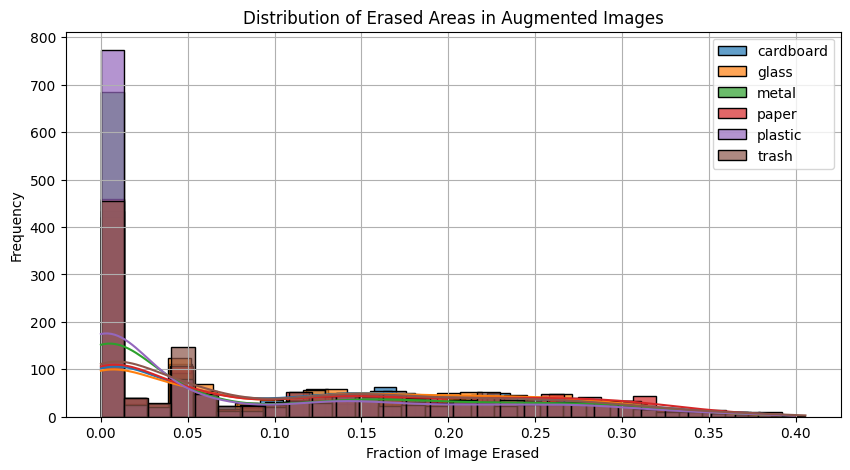

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import itertools
import seaborn as sns
import os
def compute_erased_ratio(image):
    """
    Computes the percentage of erased pixels in an image.
    """
    erased_pixels = np.sum(image == 0)  # Count black pixels
    total_pixels = image.shape[0] * image.shape[1] * image.shape[2]
    return erased_pixels / total_pixels

def analyze_erased_areas(dataset_path):
    """
    Plots a histogram of erased area percentages across all classes.
    """
    class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
    
    erased_ratios = {}

    for class_path in class_folders:
        class_name = os.path.basename(class_path)
        image_files = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))

        ratios = []
        for img_path in image_files:
            image = cv2.imread(img_path)
            if image is None:
                continue
            ratios.append(compute_erased_ratio(image))

        erased_ratios[class_name] = ratios

    # Plot distribution
    plt.figure(figsize=(10, 5))
    for class_name, ratios in erased_ratios.items():
        sns.histplot(ratios, bins=30, kde=True, label=class_name, alpha=0.7)

    plt.xlabel("Fraction of Image Erased")
    plt.ylabel("Frequency")
    plt.title("Distribution of Erased Areas in Augmented Images")
    plt.legend()
    plt.grid()
    plt.show()

# Run the analysis
analyze_erased_areas("../data/dataset_erasing_02/train")


Step 2: Class-wise Impact on Feature Distributions
We will now analyze how each class is affected by erasing by comparing the feature embeddings before and after augmentation using t-SNE.

c:\Users\vidia\anaconda3\envs\mlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vidia\anaconda3\envs\mlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\vidia/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 21.5MB/s]
C:\Users\vidia\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.

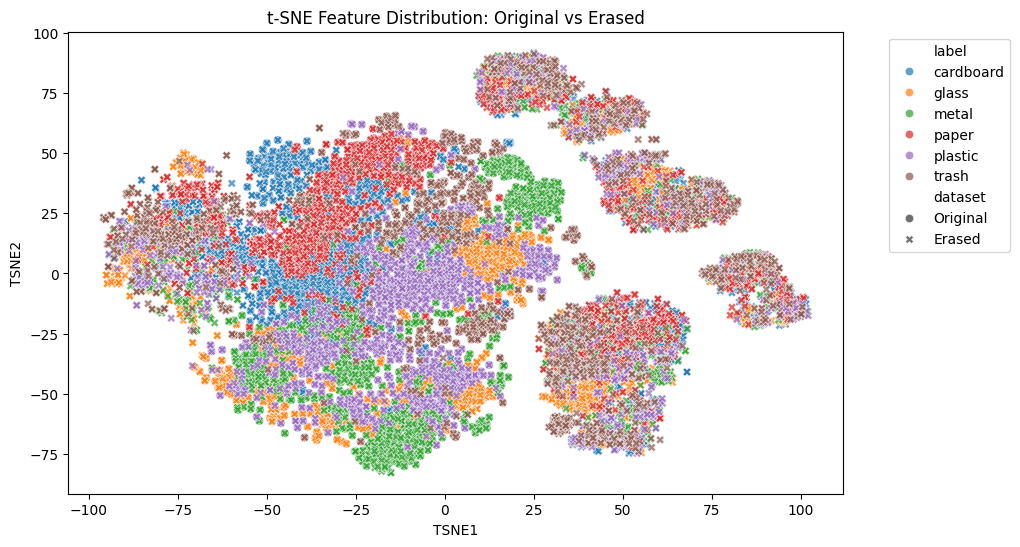

In [3]:
from sklearn.manifold import TSNE
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Load Model (ResNet-18 for embeddings)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last layer
model.to(device)
model.eval()

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

def extract_features(image_paths, labels, model):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    dataset = ImageDataset(image_paths, labels, transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    features = []
    image_labels = []

    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu().numpy())
            image_labels.extend(batch_labels)

    return np.vstack(features), image_labels

def analyze_tsne(train_path, erased_path):
    """
    Compare feature distributions before and after erasing using t-SNE.
    """
    image_paths_train = []
    labels_train = []
    image_paths_erased = []
    labels_erased = []

    class_folders = [f.path for f in os.scandir(train_path) if f.is_dir()]
    for class_path in class_folders:
        class_name = os.path.basename(class_path)
        images = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))
        image_paths_train.extend(images)
        labels_train.extend([class_name] * len(images))

    class_folders = [f.path for f in os.scandir(erased_path) if f.is_dir()]
    for class_path in class_folders:
        class_name = os.path.basename(class_path)
        images = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))
        image_paths_erased.extend(images)
        labels_erased.extend([class_name] * len(images))

    features_train, labels_train = extract_features(image_paths_train, labels_train, model)
    features_erased, labels_erased = extract_features(image_paths_erased, labels_erased, model)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    features_combined = np.vstack([features_train, features_erased])
    labels_combined = labels_train + labels_erased

    features_tsne = tsne.fit_transform(features_combined)

    # Create DataFrame
    df_tsne = pd.DataFrame(features_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels_combined
    df_tsne['dataset'] = ['Original'] * len(labels_train) + ['Erased'] * len(labels_erased)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="TSNE1", y="TSNE2", hue="label", style="dataset", data=df_tsne, palette="tab10", alpha=0.7)
    plt.title("t-SNE Feature Distribution: Original vs Erased")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Run the analysis
analyze_tsne("../data/dataset_split/train", "../data/dataset_erasing/train")


Summary of Findings & Recommendations
Based on the provided Erased Area Distribution and t-SNE Feature Distribution results:

1. Erased Area Distribution Findings (Histogram)
A large fraction of images (800+) have little to no erasing (~0%), which suggests that some images are not being augmented at all.
There is a significant spread in erased area fractions ranging from 0.1 to 0.8, meaning some images undergo excessive information loss.
The distribution of erased areas across classes is inconsistent, meaning some classes might be more affected than others.

🛠️ Recommendations:
Increase minimum erasure ratio to ensure all images receive some augmentation.
Reduce the maximum erased area (currently some images lose >50%).
Apply class-specific augmentation (e.g., less erasure on difficult classes).

2. t-SNE Feature Distribution Findings
The original and erased samples are clustered in similar regions, indicating that the augmentation still preserves some feature consistency.
However, erased samples seem more spread out (higher variance), which can cause instability during training.
Some class overlap is increased, meaning that certain categories are harder to distinguish after augmentation.

🛠️ Recommendations:

Reduce erased area per image to prevent loss of distinguishing features.
Introduce per-class augmentation tuning (e.g., less aggressive erasing for visually similar classes like plastic and glass).
Experiment with soft erasing techniques, like blending erased areas with noise or mean pixel values.